In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [2]:
import zipfile
import os
import random

In [27]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from PIL import Image

from tqdm import tqdm

In [4]:
zip_path = r'/kaggle/input/food-101/food-101/food-101'
items = os.listdir(zip_path)
for item in items:
    print(item)

meta
README.txt
images
license_agreement.txt
.DS_Store


In [113]:
! cat /kaggle/input/food-101/food-101/food-101/README.txt

Readme

Structure:
----------
pec/
    images/
        <class_name>/
            <image_id>.jpg
    meta/
        classes.txt
        labels.txt
        test.json
        test.txt
        train.json
        train.txt

All images can be found in the "images" folder and are organized per class. All
image ids are unique and correspond to the foodspotting.com review ids. Thus
the original articles can retrieved trough
  http://www.foodspotting.com/reviews/<image_id>
or through the foodspotting api (http://www.foodspotting.com/api).

The test/train splitting used in the experiment of our paper, can be found in
the "meta" directory.

For any questions contact bossard@vision.ee.ethz.ch



In [6]:
meta_path = os.path.join(zip_path, 'meta')
images_path = os.path.join(zip_path, 'images')
classes_path = os.path.join(meta_path, 'classes.txt')
train_path = os.path.join(meta_path, 'train.txt')
test_path = os.path.join(meta_path, 'test.txt')

In [12]:
test_size = 0
with open(test_path, 'r') as test:
    for line in test:
        test_size += 1
test_size


25250

In [11]:
train_size = 0
with open(train_path, 'r') as train:
    for line in train:
        train_size += 1
train_size

75750

In [123]:
print('Train и Test разделены в отношении 75/25')

Train и Test разделены в отношении 75/25


In [8]:
with open(classes_path, 'r') as file:
    classes = [line.strip() for line in file]


In [126]:
classes_count = pd.Series(index=classes)
for class_name in classes:
    file_count = 0
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if os.path.isfile(os.path.join(class_path, filename)):
            file_count += 1
    classes_count.loc[class_name] = file_count

<Axes: >

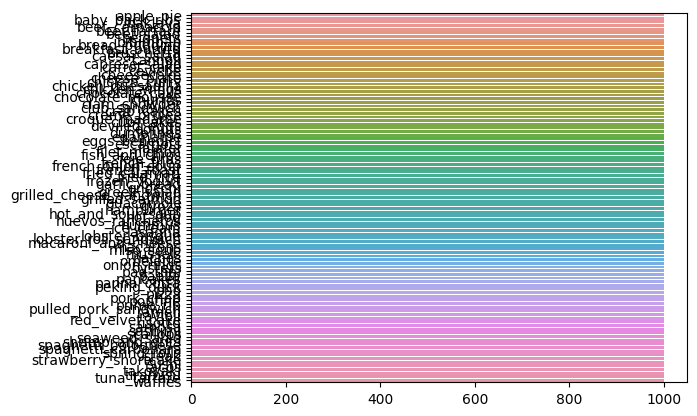

In [136]:
sns.barplot(y=classes_count.index, x=classes_count)

In [137]:
classes_count.unique()

array([1000.])

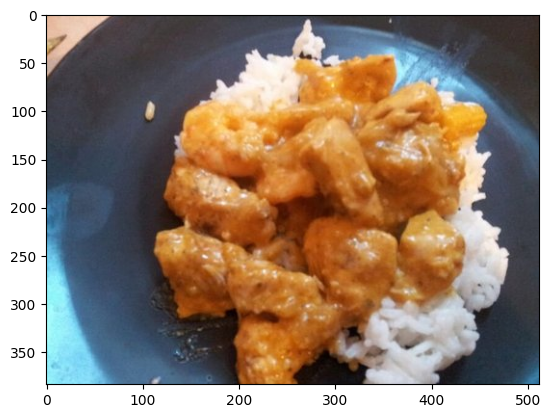

(None, 'chicken_curry')

In [197]:
random_class = random.sample(classes, 1)[0]
class_path = os.path.join(images_path, random_class)
random_image = random.choice(os.listdir(class_path))
image_path = class_path + '/' + random_image

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show(), random_class

In [9]:
# Кодируем классы
encoder = LabelEncoder()
encoder.fit(classes)

LabelEncoder()

In [13]:
train_images = pd.DataFrame(columns=['class_name', 'img_id'], index=[i for i in range(train_size)])

with open(train_path, 'r',) as text:
    lines = text.read().split()
    for i, line in enumerate(lines):
        class_name, img_id = line.split('/')
        train_images.loc[i] = [class_name, img_id]

In [176]:
train_images.groupby('class_name').size()

class_name
apple_pie         750
baby_back_ribs    750
baklava           750
beef_carpaccio    750
beef_tartare      750
                 ... 
tacos             750
takoyaki          750
tiramisu          750
tuna_tartare      750
waffles           750
Length: 101, dtype: int64

In [177]:
train_images['img_id'].nunique()

75750

In [14]:
test_images = pd.DataFrame(columns=['class_name', 'img_id'], index=[i for i in range(test_size)])

with open(test_path, 'r',) as text:
    lines = text.read().split()
    for i, line in enumerate(lines):
        class_name, img_id = line.split('/')
        test_images.loc[i] = [class_name, img_id]

In [179]:
test_images.groupby('class_name').size()

class_name
apple_pie         250
baby_back_ribs    250
baklava           250
beef_carpaccio    250
beef_tartare      250
                 ... 
tacos             250
takoyaki          250
tiramisu          250
tuna_tartare      250
waffles           250
Length: 101, dtype: int64

In [178]:
test_images['img_id'].nunique()

25250

In [300]:
print('Все изображения уникальны, классы сбалансированны')

Все изображения уникальны, классы сбалансированны


In [15]:
def get_image_path(x):
    path = os.path.join(images_path, *x.values)
    path += '.jpg'
    return path

In [16]:
train_images['img_path'] = train_images.apply(get_image_path, axis=1)
test_images['img_path'] = test_images.apply(get_image_path, axis=1)

In [17]:
train_images['label_encoded'] = encoder.transform(train_images['class_name'])
test_images['label_encoded'] = encoder.transform(test_images['class_name'])

In [201]:
train_images.head(3)

,class_name,img_id,img_path,label_encoded
0,apple_pie,1005649,/kaggle/input/food-101/food-101/food-101/image...,0
1,apple_pie,1014775,/kaggle/input/food-101/food-101/food-101/image...,0
2,apple_pie,1026328,/kaggle/input/food-101/food-101/food-101/image...,0


In [206]:
from PIL import Image
images_size = pd.DataFrame(columns=['width', 'height'], index=train_images.index, dtype=np.int16)
for i, path in enumerate(train_images['img_path'].values):
    image = Image.open(path)
    width, height = image.size
    images_size.loc[i] = (width, height)

KeyboardInterrupt: 

In [214]:
images_size.dropna().describe()

,width,height
count,55720.000000,55720.000000
mean,495.806281,475.725341
std,45.735804,65.158667
min,193.000000,122.000000
25%,512.000000,487.000000
50%,512.000000,512.000000
75%,512.000000,512.000000
max,512.000000,512.000000


In [317]:
from torchvision.transforms import v2
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomRotation([-30, 30]),
    v2.Resize(size=(224, 224), antialias=True), 
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [216]:
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.data = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx]['img_path']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.data.loc[idx]['label_encoded']
        
        return img, label
        

In [ ]:
test_images_shuffled = test_images.sample(frac=1, random_state=22).reset_index(drop=True)

In [318]:
train_dataset = FoodDataset(train_images, train_transforms)
test_dataset = FoodDataset(test_images_shuffled, test_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [319]:
def train(model, num_epochs, train_dataloader, test_dataloader, optimizer, loss):
    best_score = 0.0
    
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        for inputs, labels in tqdm(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
    
        tp = eval_(model, test_dataloader)
        acc = tp / 25250
    
        if acc > best_score:
            best_score = acc
            best_model_weights = model.state_dict()
    
        epoch_loss = running_loss / len(train_dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {acc:.4f}')
        
    return best_model_weights
        
def eval_(model, test_dataloader):
    tp=0
    model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                preds, y = torch.argmax(F.softmax(outputs, dim=1), dim=1).to('cpu').numpy(), y.to('cpu').numpy()
                tp += (preds == y).sum()
                
        return tp

In [332]:
efficientNet = models.efficientnet_b0(pretrained=True)
in_features = efficientNet.classifier[1].in_features 
efficientNet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, 101)
)

efficientNet = efficientNet.to(device)

for param in efficientNet.parameters():
    param.requires_grad = False

efficientNet.classifier[1].weight.requires_grad = True
efficientNet.classifier[1].bias.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientNet.parameters(), lr=0.01)


In [333]:
_ = train(efficientNet, 1, train_dataloader, test_dataloader, optimizer, criterion)

100%|██████████| 592/592 [21:49<00:00,  2.21s/it]


Epoch [1/1], Loss: 2.9362
Epoch [1/1], Accuracy: 0.4845


In [321]:
resnet50 = models.resnet50(weights='IMAGENET1K_V2')
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, 101)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet50 = resnet50.to(device)

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc.weight.requires_grad = True
resnet50.fc.bias.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.01)

In [322]:
best_weights = train(resnet50, 3, train_dataloader, test_dataloader, optimizer, criterion)

 10%|█         | 60/592 [02:10<19:15,  2.17s/it]


KeyboardInterrupt: 

In [306]:
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, 101)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = resnet18.to(device)

for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc.weight.requires_grad = True
resnet18.fc.bias.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.01)


In [307]:
_ = train(resnet18, 1, train_dataloader, test_dataloader, optimizer, criterion)

100%|██████████| 592/592 [08:51<00:00,  1.11it/s]


Epoch [1/1], Loss: 3.5608
Epoch [1/1], Accuracy: 0.4513


In [299]:
resnet50 = models.resnet50(weights='IMAGENET1K_V2')
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, 101)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc.weight.requires_grad = True
resnet50.fc.bias.requires_grad = True


In [287]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.01)

In [292]:
best_weights = train(resnet50, 4, train_dataloader, test_dataloader, optimizer, criterion)

100%|██████████| 4/4 [44:00<00:00, 660.21s/it]


Epoch [4/4], Loss: 2.6597
Epoch [4/4], Accuracy: 0.5254


In [256]:
import pickle as pkl
with open('encoder.pkl', 'wb') as f:
    pkl.dump(encoder, f)

In [255]:
torch.save(resnet50.state_dict(), 'resnet50_weights.pth')

In [222]:
eval_(resnet50, test_dataloader) / len(test_dataset)

0.6194851485148515

In [334]:
results = pd.DataFrame(columns=['Model', 'Epochs', 'Accuracy'])
results.loc[0, :] = ('ResNet50', 1, 0.61)
results.loc[1, :] = ('ResNet18', 1, 0.45)
results.loc[2, :] = ('EfficientNet', 1, 0.48)
results

,Model,Epochs,Accuracy
0,ResNet50,1,0.61
1,ResNet18,1,0.45
2,EfficientNet,1,0.48


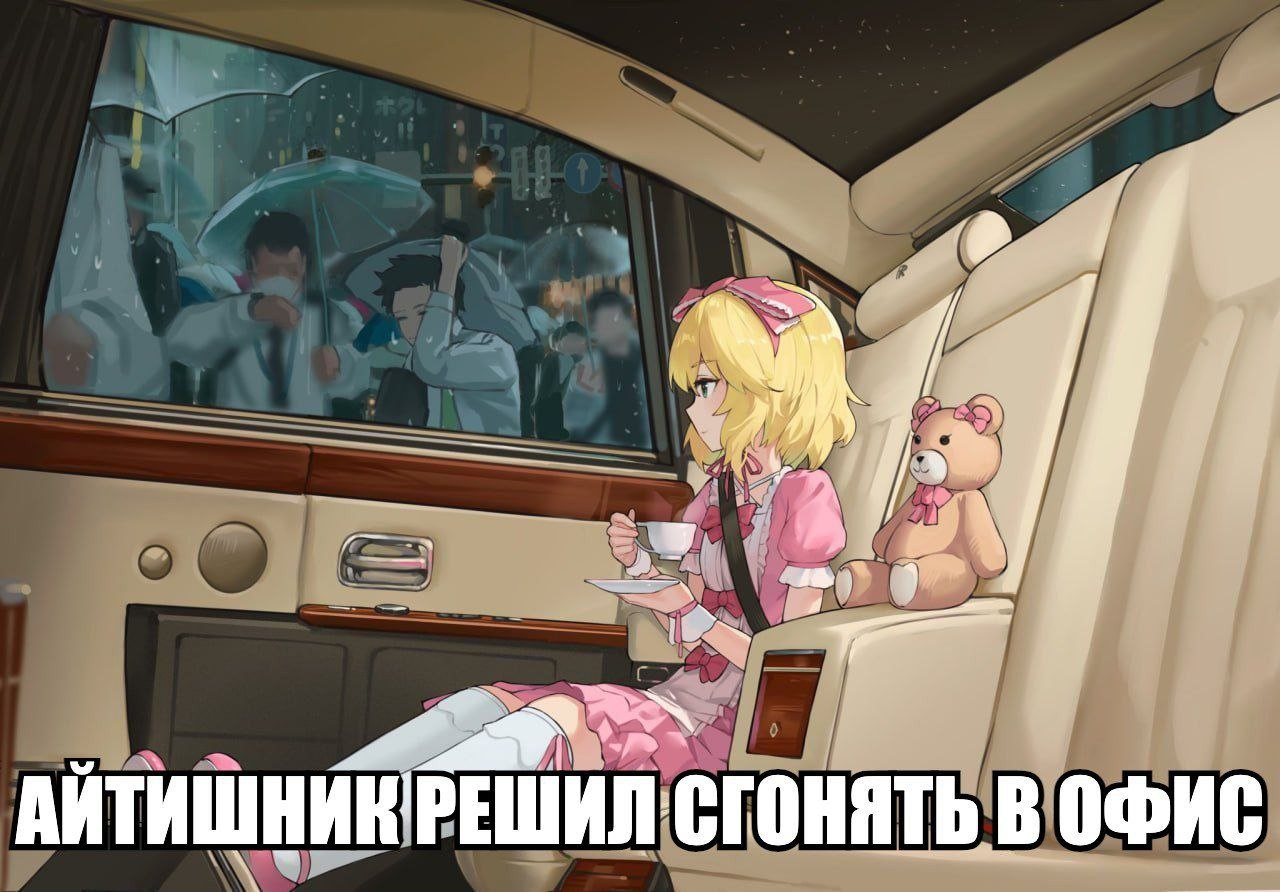